# Ridge Regularization Regression

Ridge regression can overcome the overfitting problem brought on by so many features in the dataset.

**Ridge Regression**:
L2 penalized model where the Square Sum of the weights term is added to Ordinary Least Squares cost function. As hyperparameter λ increases, Ridge regression introduces more bias into the model, so the training data does not fit well initially, yet overfitting of the test data decreases in the long run. Ridge regression minimizes (penalizes) the effect of irrelevant features as the strength of regularization growth.

In other words: Ridge Regression works to find a line that doesn't fit the training data as well (by introducing bias into the model) but in return results in a significant drop in variance. By starting with a slightly worse fit, Ridge Regression can provide better long term predictions.

The below feature engineering and data imputation helps to improve the final score:

- Log transform the y variable since the evaluation is based on the RMSE of the logarithm of the predicted house and observed sales price 
- Exclude outliers
- Get rid of multicollinearity features 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.special import boxcox1p

# Modeling packages
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
# create training and test dataframes
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')

In [7]:
# shape of the data prior to processing
print ('Shape of Train set: {}'.format(df_train.shape))
print ('Shape of Test set: {}'.format(df_test.shape))

# ID column does not affect the prediction outcome hence can be dropped. 
# However the ID series are saved for future modeling
test_id = df_test['Id']
train_id = df_train['Id']

# Dropping ID column
df_test.drop("Id", axis = 1, inplace = True)
df_train.drop("Id", axis = 1, inplace = True)

# shape of the data after processing
print ('\nShape of Train set after removing Id: {}'.format(df_train.shape))
print ('Shape of Test set after removing Id: {}'.format(df_test.shape))

Shape of Train set: (1460, 81)
Shape of Test set: (1459, 80)

Shape of Train set after removing Id: (1460, 80)
Shape of Test set after removing Id: (1459, 79)


In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Normalize Target Feature

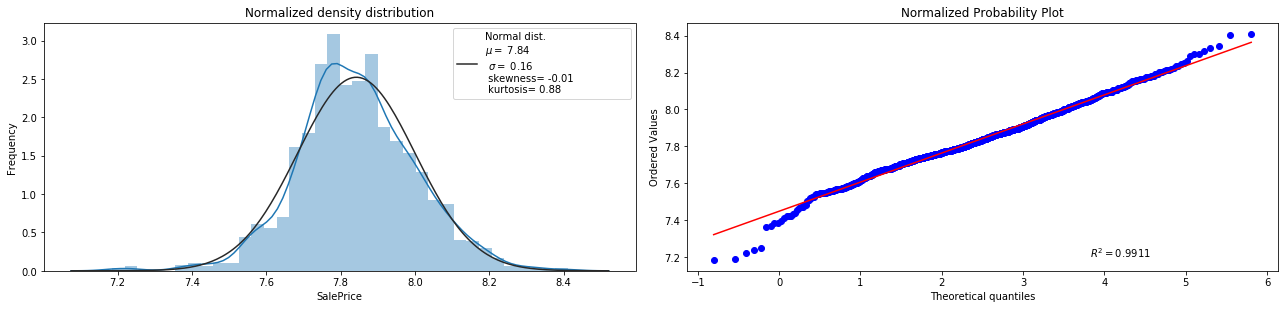

In [8]:
# normalize target feature

def normalize_feat(feature):
    
    df_train[feature] = stats.boxcox(df_train[feature])[0]

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df_train[feature])
    (mu_norm, sigma_norm) = norm.fit(df_train[feature])

    # skewness and kurtosis
    transf_skew = df_train[feature].skew()
    transf_kurt = df_train[feature].kurt()

    # set size for plots
    plt.figure(figsize=(18,8))
    
    # plot Normalized distribution
    plt.subplot(223)
    sns.distplot(df_train[feature] , fit=norm)
    plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \
                \n kurtosis= {:.2f}'.format(mu_norm, sigma_norm, transf_skew, transf_kurt)],loc='best')

    plt.ylabel('Frequency')
    plt.title('Normalized density distribution')

    # QQ-plot for Normalized distribution
    plt.subplot(224)
    res = stats.probplot(df_train[feature], sparams=(2.5,), plot=plt, rvalue=True)
    plt.title('Normalized Probability Plot')
    plt.tight_layout()
    
normalize_feat('SalePrice')

In [9]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,7.932608
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,7.878261
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7.959616
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,7.774953
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,8.002873


### Removing Outliers and Reducing Multcolinearity

From the heat maps, we can see that there are several features highly correlated. These will cause multicollinearity, so dropping one of them may work in our favor.

Possibilities: 
- YearBuilt and GarageYrBlt. This is reasonable since many times YearBuilt and GarageYrBlt will be the same. Drop GarageYrBlt.
- GrLivArea and TotRmsAbvGrd, drop TotRmsAbvGrd
- 1stFlrSF and TotalBsmtSF, drop TotalBsmtSF

In [10]:
# make copies of datasets to reduce confusion with other models
ridge_train = df_train.copy()
ridge_test = df_test.copy()

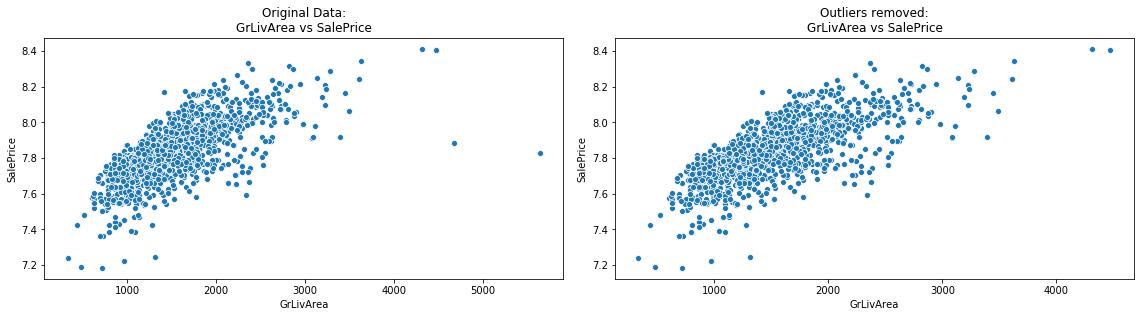

In [11]:
# removing outliers
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.scatterplot(x=ridge_train['GrLivArea'],y=ridge_train['SalePrice'])
plt.title('Original Data:\nGrLivArea vs SalePrice')

# Removing two outliers with larger living area and low sale price
ridge_train = ridge_train.drop(ridge_train.sort_values(by = 'GrLivArea', ascending = False)[:2].index)

plt.subplot(222)
sns.scatterplot(x=ridge_train['GrLivArea'],y=ridge_train['SalePrice'])
plt.title('Outliers removed:\nGrLivArea vs SalePrice')

plt.tight_layout()

In [12]:
# reducing multicollinearity
ridge_train.drop(['GarageYrBlt','TotRmsAbvGrd','TotalBsmtSF'], axis=1, inplace=True)
ridge_test.drop(['GarageYrBlt','TotRmsAbvGrd','TotalBsmtSF'], axis=1, inplace=True)

In [13]:
ridge_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,7.932608
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,7.878261
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7.959616
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,7.774953
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,8.002873


### Missing Value Imputation

#### Combining Train and Test sets to impute all values at once

In [14]:
# Combining Train and Test data sets
ridge_all_data = pd.concat((ridge_train, ridge_test), sort=False).reset_index(drop=True)
ridge_all_data.drop(['SalePrice'], axis=1, inplace=True)

ridge_all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [15]:
# Will use this to split into train and test after imputation
ntrain = ridge_train.shape[0] 
ntest = ridge_test.shape[0]
y_train = ridge_train['SalePrice'].values
y_test = ridge_train['SalePrice'].values 

There are multiple types of missing values as seen in the exploratory data analysis. They cannot all be treated the same way. 

The following features' missing values will be filled with **None** as the fact that they are missing indicates that the feature is not present in the particular house: 
- 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'

The following features' missing values will be filled with the most common value (the **mode**), as it is probable that this is the missing value:
- 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'Utilities', 'SaleType', 'Functional'

The following numerical features' missing values will be filled with **zero**, as the fact that they are missing indicates the feature is not present:
- 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'

In [16]:
Cat_toNone = ('PoolQC','Fence','MiscFeature','Alley','FireplaceQu','GarageType','GarageFinish',
              'GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','MasVnrType','MSSubClass')
    
Cat_toMode = ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd',
              'Utilities','SaleType','Functional')

Num_toZero = ('GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
              'BsmtFullBath','BsmtHalfBath','MasVnrArea')

for col in Cat_toNone:
    ridge_all_data[col]=ridge_all_data[col].fillna('None')

for col in Cat_toMode:
    ridge_all_data[col]=ridge_all_data[col].fillna(ridge_all_data[col].mode()[0])
    
for col in Num_toZero:
    ridge_all_data[col]=ridge_all_data[col].fillna(0)

**LotFrontage** missing data requires deeper analysis.

- Since LotFrontage is the distance of house's front yard, we can make an assumption that it depends on the neighborhood where the house is located. This way we can group LotFrontage values by the neighborhood feature and substitute missing values by the median Lotfrontage distance of the neighborhood. 

In [17]:
ridge_all_data["LotFrontage"] = ridge_all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Skewed features transformation and creating dummy variables

Skewed features need to be normalized through transformation. Box-Cox method with normalization lambda parameter = 0.15.

In [18]:
def bcox_transform(df):
    '''
    IN: Original dataframe 
    OUT: Dataframe with box-cox normalized numerical values. 
    Specified skewness threshold 1 and -1 
    '''
    lam = 0.15
    for feat in df._get_numeric_data():
        if df[feat].skew()>1.0 or df[feat].skew()<-1.0:
            df[feat]=boxcox1p(df[feat], lam)
    return df

ridge_all_data = bcox_transform(ridge_all_data)

In [19]:
# create dummy variables for all categorical variables
ridge_all_data = pd.get_dummies(ridge_all_data)

In [20]:
# splitting data back to train and test data sets
ridge_train = ridge_all_data[:ntrain]
ridge_test = ridge_all_data[ntrain:]

In [21]:
# create train validation split
X_train = ridge_all_data[:ridge_train.shape[0]]
X_test = ridge_all_data[ridge_train.shape[0]:]
y = y_train # using code from above

### Definining cross-validation

In [22]:
n_folds = 15

# K-fold Root Mean Square Error Cross Validation
def k_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(ridge_train.values)
    rmse= np.sqrt(-cross_val_score(model, ridge_train.values, y_train, 
                                   scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Model

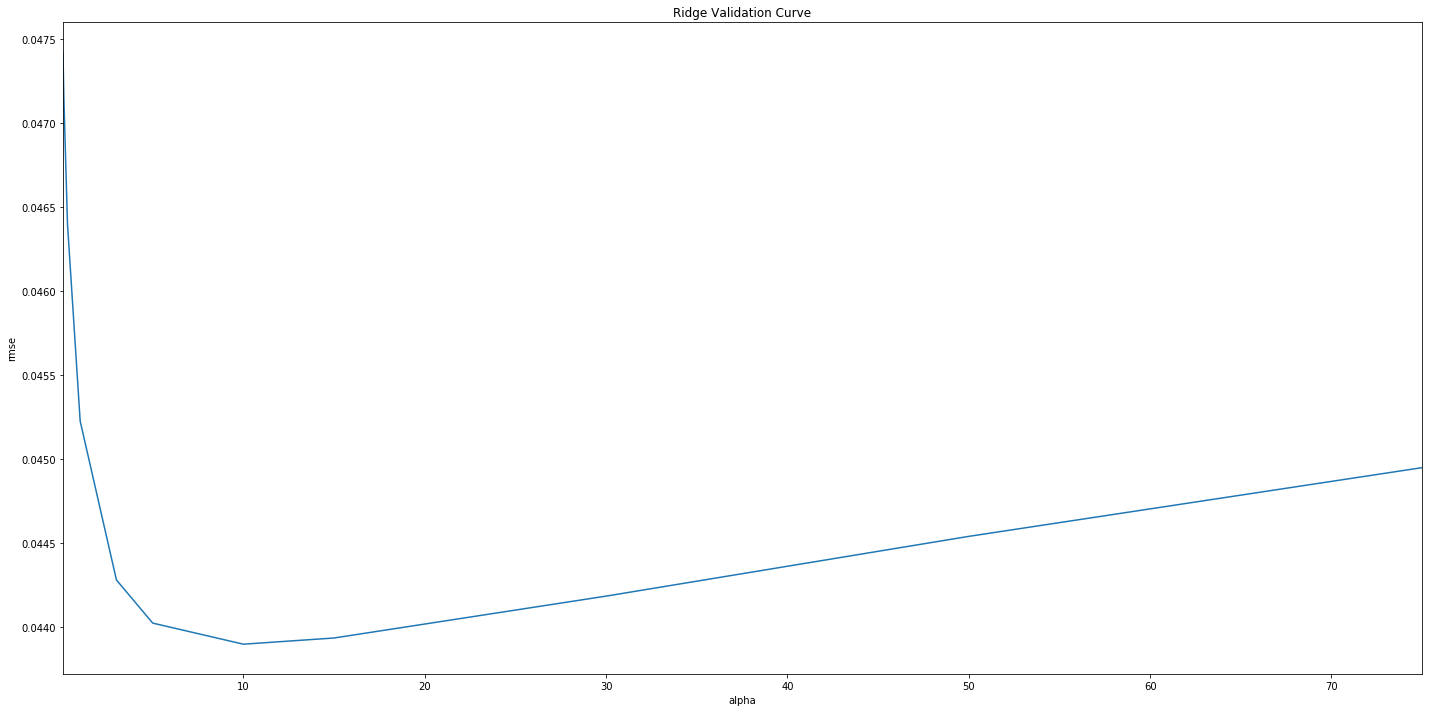

In [23]:
# define model
model_ridge = Ridge()

# Tuning hyperparameter alpha as our hyperparameter lambda
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# Evaluating model through k-fold cross-validation defined earlier
cv_ridge = [k_rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)

# Plot validation curve
plt.figure(figsize=(20,10))

#plt.subplot()
cv_ridge.plot(title = "Ridge Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.tight_layout()

Ridge regression shows the lowest RMSE value at alpha = 10

In [28]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
    print('RMSE: {:.4}'.format(rmse))

# fit model
model_ridge = Ridge(alpha = 10)
model_ridge.fit(ridge_train, y_train)
model_ridge_pred = model_ridge.predict(ridge_test)
ridge_pred = np.expm1(model_ridge.predict(ridge_test.values))

#print('Accuracy: {:.4f}'.format(model_ridge.score(ridge_test, ridge_test.values)))



In [30]:
model_ridge.score(ridge_test, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1458, 1459]